In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [23]:
#import data
df= pd.read_excel(r'/Users/jessiecai/Desktop/筆試題目/3-1.xls')
df.head()

,date,price,quote,volume,fi_over,fi_per,cr_over,se_over,finan_over,finan_diff,lend_over,lend_diff,over_1000
0,2020-08-07,148.5,-5.41,48472.0,-1869.0,30.2,-1511.0,-914.0,-4294.0,27.0,8200.0,-322.0,48.29
1,2020-07-31,157.0,8.28,98040.0,1799.0,30.9,340.0,-703.0,1436.0,-562.0,8173.0,481.0,51.42
2,2020-07-24,145.0,3.94,53790.0,-471.0,30.1,533.0,-370.0,-308.0,1389.0,8735.0,294.0,50.65
3,2020-07-17,139.5,-1.06,44506.0,-243.0,30.2,21.8,-608.0,-829.0,-297.0,7346.0,598.0,51.59
4,2020-07-10,141.0,7.63,104124.0,-1471.0,30.4,50.0,594.0,-827.0,-265.0,7643.0,539.0,50.27


In [167]:
data=df.drop(['date'], axis=1)
data.index=df.date
data_test=data[1:20]
data_run=data[21:101]

In [168]:
# 缺失值處理
data_run[data_run.isnull().values==True] # 缺失值僅兩列，因此決定刪除這兩列

df_na= data.dropna(axis=0)
df1=df_na.reindex(index=df_na.index[::-1])
df1.tail()

,price,quote,volume,fi_over,fi_per,cr_over,se_over,finan_over,finan_diff,lend_over,lend_diff,over_1000
date,,,,,,,,,,,,
2020-07-10,141.0,7.63,104124.0,-1471.0,30.4,50.0,594.0,-827.0,-265.0,7643.0,539.0,50.27
2020-07-17,139.5,-1.06,44506.0,-243.0,30.2,21.8,-608.0,-829.0,-297.0,7346.0,598.0,51.59
2020-07-24,145.0,3.94,53790.0,-471.0,30.1,533.0,-370.0,-308.0,1389.0,8735.0,294.0,50.65
2020-07-31,157.0,8.28,98040.0,1799.0,30.9,340.0,-703.0,1436.0,-562.0,8173.0,481.0,51.42
2020-08-07,148.5,-5.41,48472.0,-1869.0,30.2,-1511.0,-914.0,-4294.0,27.0,8200.0,-322.0,48.29


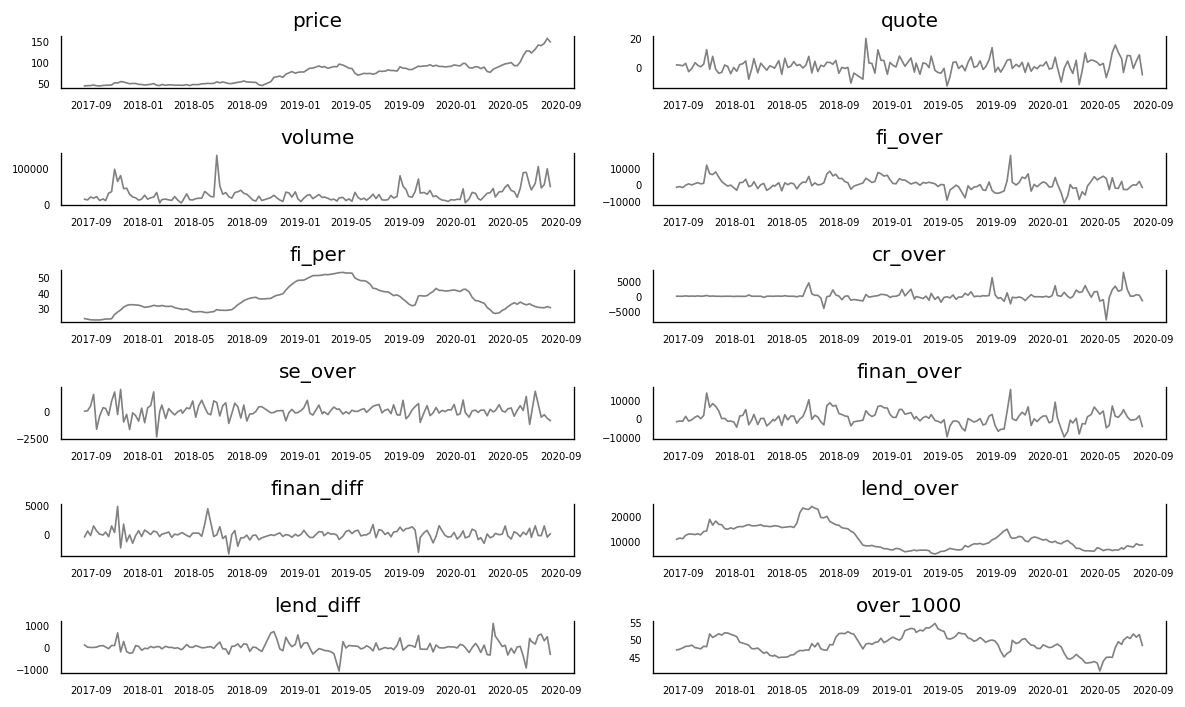

In [169]:
# Plot
fig, axes= plt.subplots(nrows=6, ncols=2, dpi=120, figsize=(10, 6))
for i, ax in enumerate(axes.flatten()):
    data1=df1[df1.columns[i]]
    ax.plot(data1, color='grey', linewidth=1)
    ax.set_title(df1.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [170]:
# Granger's Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test= 'ssr_chi2test'
def granger_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df= pd.DataFrame(np.zeros((len(variables), len(variables))), columns= variables, index= variables)
    for c in df.columns:
        for r in df.index:
            test_result= grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values= [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y={r}, X={c}, P Value={p_values}')
            min_p_value=np.min(p_values)
            df.loc[r, c]=min_p_value
    df.columns= [var+'_x' for var in variables]
    df.index= [var+'_y' for var in variables]
    return df

gcm=granger_causation_matrix(df1, variables= df1.columns)
gcm
# 只有price and lend_diff p值<0.05，不適用VAR model

,price_x,quote_x,volume_x,fi_over_x,fi_per_x,cr_over_x,se_over_x,finan_over_x,finan_diff_x,lend_over_x,lend_diff_x,over_1000_x
price_y,1.0000,0.0958,0.5479,0.5068,0.0554,0.0065,0.1907,0.2382,0.1607,0.4357,0.0042,0.0069
quote_y,0.0071,1.0000,0.4336,0.5178,0.1506,0.1581,0.1127,0.3002,0.0982,0.2393,0.0745,0.0077
volume_y,0.0629,0.1255,1.0000,0.3993,0.0159,0.0000,0.0073,0.0270,0.0023,0.0055,0.5172,0.0014
fi_over_y,0.0292,0.4342,0.4197,1.0000,0.0334,0.0016,0.2895,0.0780,0.0133,0.0512,0.0852,0.1093
fi_per_y,0.0796,0.0351,0.3795,0.0000,1.0000,0.0022,0.1587,0.0000,0.0669,0.1089,0.0538,0.4038
cr_over_y,0.1243,0.2864,0.0629,0.1519,0.1007,1.0000,0.6383,0.1413,0.4713,0.5288,0.0547,0.0183
se_over_y,0.4202,0.2259,0.1071,0.0193,0.0868,0.0006,1.0000,0.0461,0.0010,0.0039,0.0229,0.0704
finan_over_y,0.0882,0.3884,0.1153,0.1275,0.0459,0.0630,0.4345,1.0000,0.0048,0.0418,0.0483,0.1047
finan_diff_y,0.5993,0.0927,0.0005,0.0148,0.0177,0.5215,0.0179,0.0267,1.0000,0.2100,0.2132,0.3462
lend_over_y,0.2964,0.0666,0.0010,0.1142,0.0461,0.3722,0.0538,0.1662,0.1898,1.0000,0.2930,0.2557


In [174]:
# Cointergration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointergration_test(df, alpha=0.05):
    out= coint_johansen(df, -1, 5)
    d= {'0.90':0, '0.95':1, '0.99':2}
    traces= out.lr1
    cvts= out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length=6): return str(val).ljust(length)
    
    print('Name :: Test Stat >  C(95%)  =>  Signif')
    for col, trace, cvt in zip(df2.columns, traces, cvts):
        print(adjust(col), '::', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), '=>', trace>cvt)

cointergration_test(df1)

Name :: Test Stat >  C(95%)  =>  Signif
quote  :: 458.14    > 311.1288 => True
fi_over :: 375.37    > 263.2603 => True
cr_over :: 302.27    > 219.4051 => True
se_over :: 242.89    > 179.5199 => True
finan_over :: 185.14    > 143.6691 => True
lend_diff :: 135.26    > 111.7797 => True


In [176]:
nobs=20
df_train, df_test= df1[0:-20], df1[-nobs: ]
df_train.shape #(133, 12)
df_test.shape #(20, 12)

(20, 12)

In [177]:
# ADF Test
def adfuller_test(series, signif= 0.05, name='', verbose=False):
    r= adfuller(series, autolag='AIC')
    output= {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags': round(r[2],4), 'n_obs': r[3]}
    p_value= output['pvalue']
    def adjust(val, length=6): return str(val).ljust(length)
    
    print(f' Augmented Dickey-Fuller Test on "{name}"', "\n", "-"*47)
    print(f' Null Hypothesis: Data has until root. Non-Stationary. ')
    print(f' Significance Level   = {signif}')
    print(f' Test Statistic          = {output["test_statistic"]}')
    print(f' No. Lags Chosen     = {output["n_lags"]}')
          
    if p_value <= signif:
        print(f' => P-Value ={p_value}. Rejecting Null Hypothesis')
        print(f' => Series is Stationary')
    else:
        print(f' => P-Value={p_value}. Weak evidence to reject the Null Hypothesis')
        print(f' => Series is Non-Stationary.')

# ADF Test on each columns
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')
          
#None of the time series is stationary

 Augmented Dickey-Fuller Test on "price" 
 -----------------------------------------------
 Null Hypothesis: Data has until root. Non-Stationary. 
 Significance Level   = 0.05
 Test Statistic          = -1.3347
 No. Lags Chosen     = 0
 => P-Value=0.6131. Weak evidence to reject the Null Hypothesis
 => Series is Non-Stationary.


 Augmented Dickey-Fuller Test on "quote" 
 -----------------------------------------------
 Null Hypothesis: Data has until root. Non-Stationary. 
 Significance Level   = 0.05
 Test Statistic          = -12.1959
 No. Lags Chosen     = 0
 => P-Value =0.0. Rejecting Null Hypothesis
 => Series is Stationary


 Augmented Dickey-Fuller Test on "volume" 
 -----------------------------------------------
 Null Hypothesis: Data has until root. Non-Stationary. 
 Significance Level   = 0.05
 Test Statistic          = -7.2741
 No. Lags Chosen     = 0
 => P-Value =0.0. Rejecting Null Hypothesis
 => Series is Stationary


 Augmented Dickey-Fuller Test on "fi_over" 
 -------

In [179]:
# 1st differece
df_differenced= df_train.diff().dropna()

#ADF Test on each colun of 1st Differemces Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

 Augmented Dickey-Fuller Test on "price" 
 -----------------------------------------------
 Null Hypothesis: Data has until root. Non-Stationary. 
 Significance Level   = 0.05
 Test Statistic          = -11.2942
 No. Lags Chosen     = 0
 => P-Value =0.0. Rejecting Null Hypothesis
 => Series is Stationary


 Augmented Dickey-Fuller Test on "quote" 
 -----------------------------------------------
 Null Hypothesis: Data has until root. Non-Stationary. 
 Significance Level   = 0.05
 Test Statistic          = -6.7442
 No. Lags Chosen     = 8
 => P-Value =0.0. Rejecting Null Hypothesis
 => Series is Stationary


 Augmented Dickey-Fuller Test on "volume" 
 -----------------------------------------------
 Null Hypothesis: Data has until root. Non-Stationary. 
 Significance Level   = 0.05
 Test Statistic          = -9.6595
 No. Lags Chosen     = 2
 => P-Value =0.0. Rejecting Null Hypothesis
 => Series is Stationary


 Augmented Dickey-Fuller Test on "fi_over" 
 --------------------------------

In [182]:
# Select the order
model= VAR(df_differenced)
for i in range(10):
    result= model.fit(i)
    print('Lag Order= ', i)
    print('AIC: ', result.aic)
    print('BIC: ', result.bic)
    print('FPE: ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
#use lag 3 model 

Lag Order=  0
AIC:  104.10378729424544
BIC:  104.36586019629874
FPE:  1.628177983277873e+45
HQIC:  104.21028169780182 

Lag Order=  1
AIC:  96.94529298457508
BIC:  100.36919208701309
FPE:  1.2770896661523396e+42
HQIC:  98.33657619845017 

Lag Order=  2
AIC:  96.47516879779064
BIC:  103.09255599114968
FPE:  8.392786364696386e+41
HQIC:  99.16403434804286 

Lag Order=  3
AIC:  96.30914968875895
BIC:  106.15222494098052
FPE:  8.181131624586954e+41
HQIC:  100.30859042884221 

Lag Order=  4
AIC:  96.67607174693698
BIC:  109.77758577181773
FPE:  1.5847400736113055e+42
HQIC:  101.99928378353863 

Lag Order=  5
AIC:  96.44420486710287
BIC:  112.83747216858075
FPE:  2.1587266972795234e+42
HQIC:  103.10459156614236 

Lag Order=  6
AIC:  96.5242576657644
BIC:  116.24316997123658
FPE:  5.971969600471823e+42
HQIC:  104.53543373931716 

Lag Order=  7
AIC:  94.47921523723
BIC:  117.55825533361678
FPE:  3.8550279245923086e+42
HQIC:  103.855010912032 

Lag Order=  8
AIC:  90.13635390698522
BIC:  116.610

//anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [183]:
model_fitted=model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 15, Aug, 2020
Time:                     10:43:01
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    106.152
Nobs:                     129.000    HQIC:                   100.309
Log likelihood:          -7964.46    FPE:                8.18113e+41
AIC:                      96.3091    Det(Omega_mle):     3.96819e+40
--------------------------------------------------------------------
Results for equation price
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.078706         0.293818            0.268           0.789
L1.price             -0.694374         0.315946           -2.198           0.028
L1.quote              0.504444         0.234250            2

In [184]:
#DW
from statsmodels.stats.stattools import durbin_watson
def adjust(val, length=6): return str(val).ljust(length)
out= durbin_watson(model_fitted.resid)

for col, val in zip(data.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.1
quote  : 2.21
volume : 2.15
fi_over : 2.07
fi_per : 2.09
cr_over : 2.18
se_over : 1.83
finan_over : 2.12
finan_diff : 2.0
lend_over : 1.99
lend_diff : 2.03
over_1000 : 2.0


In [185]:
# Get the lag order
lag_order= model_fitted.k_ar

#Input data for forecasting
forecast_input= df_differenced.values[-lag_order:]
forecast_input

array([[ 3.800e+00,  9.070e+00,  9.807e+03,  3.020e+02, -7.000e-01,
         2.214e+03,  9.000e+00,  2.525e+03, -9.680e+02, -1.608e+03,
         3.360e+02,  9.700e-01],
       [-1.070e+01, -1.671e+01,  9.068e+03, -7.090e+03, -2.800e+00,
        -8.130e+02, -5.240e+02, -8.427e+03,  1.613e+03,  5.000e+00,
        -4.340e+02, -7.400e-01],
       [-1.900e+00,  9.730e+00,  1.476e+03,  4.709e+03, -1.500e+00,
         2.470e+02,  6.030e+02,  5.559e+03, -6.560e+02, -6.510e+02,
        -2.100e+01, -6.500e-01]])

In [186]:
#Forecast
fc= model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast= pd.DataFrame(fc, index=data.index[-nobs: ], columns=data.columns+'_2d')
df_forecast

,price_2d,quote_2d,volume_2d,fi_over_2d,fi_per_2d,cr_over_2d,se_over_2d,finan_over_2d,finan_diff_2d,lend_over_2d,lend_diff_2d,over_1000_2d
date,,,,,,,,,,,,
2017-12-22,-0.436877,0.788616,-762.917405,-1520.322700,-1.938715,1159.133175,387.040433,25.874205,1101.283756,-107.711921,398.924516,0.098003
2017-12-15,0.624829,2.489667,15483.564618,2911.962091,-1.037461,-459.265133,108.106958,2560.674359,-267.269367,-450.088188,-17.967218,-0.589730
2017-12-08,-1.671211,-2.686434,3412.824040,-1442.977919,-1.541968,763.929912,-323.195320,-1002.096389,432.515651,367.550488,-61.403750,0.126412
2017-12-01,-0.963545,0.728773,-590.922472,558.760371,-1.380961,-440.601018,613.194865,731.251788,-210.993928,-98.001994,18.176684,-0.656704
2017-11-24,-0.114493,0.648431,7568.054830,133.970639,-1.428341,743.969423,-140.842501,737.110034,639.195430,341.261361,93.262345,-0.363380
2017-11-17,0.386101,1.648422,7182.625659,1689.953461,-0.862600,-63.757630,-26.573874,1599.561710,-305.917105,230.201075,83.741294,-0.144414
2017-11-10,-0.201105,-1.081990,-314.163067,-255.424445,-0.956289,-45.201634,58.491539,-242.113823,97.516306,277.743762,-45.309249,-0.299444
2017-11-03,-0.107439,0.383757,2886.927901,597.245083,-0.854805,122.975703,208.719998,928.889454,-17.754910,251.200773,-17.578086,-0.217179
2017-10-27,-0.192980,-0.332036,4326.826771,229.698641,-0.773126,181.303613,-138.468485,272.564642,34.529296,231.934582,77.170780,-0.208455


In [201]:
df_fc=df_forecast.copy()
columns= df_train.columns
for col in columns:
    df_fc[str(col+'_forecast')]= df_train[col].iloc[-1]+ df_fc[col].cumsum()
df_fc

KeyError: 'price'